<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Выгрузка-данных" data-toc-modified-id="Выгрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Выгрузка данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных-(EDA)" data-toc-modified-id="Исследовательский-анализ-данных-(EDA)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных (EDA)</a></span></li><li><span><a href="#Прогноз-оттока-клиентов" data-toc-modified-id="Прогноз-оттока-клиентов-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Прогноз оттока клиентов</a></span></li><li><span><a href="#Кластеризация-клиентов" data-toc-modified-id="Кластеризация-клиентов-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Кластеризация клиентов</a></span></li><li><span><a href="#Выводы-и-рекомендации" data-toc-modified-id="Выводы-и-рекомендации-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы и рекомендации</a></span></li></ul></div>

# Анализ оттока клиентов фитнес-центров «Культурист-датасаентист»
# Постановка задачи, описание данных

**Задача** — провести анализ и подготовить план действий по удержанию клиентов.  

**Данные клиента за предыдущий до проверки факта оттока месяц:**  
'gender' — пол;  
'Near_Location' — проживание или работа в районе, где находится фитнес-центр;  
'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);  
Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);  
'Phone' — наличие контактного телефона;  
'Age' — возраст;  
'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).  

**Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:**  
'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);  
'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);  
'Group_visits' — факт посещения групповых занятий;  
'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;  
'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;  
'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.  
'Churn' — факт оттока в текущем месяце.  

## Выгрузка данных

Импортируем библиотеки, которые нам понадобятся. Загрузим данные.

In [9]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
#pd.set_option('display.max_colwidth', None)
warnings.filterwarnings('ignore')
# Инициализация моделей линейной регрессии
from sklearn.linear_model import LogisticRegression
# Инициализация моделей случайного леса
from sklearn.ensemble import RandomForestClassifier
#метрики
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
#создание выборк
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from itertools import combinations

In [10]:
#выгрузка данных
try:
    gym_churn = pd.read_csv(r'C:\datasets\gym_churn.csv') # гипотезы 
except:
    gym_churn = pd.read_csv('/datasets/gym_churn.csv') 
    
   #ознакомимся с таблицами и проверим тип данных
gym_churn.info()
gym_churn.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Пропусков нет.  
Также можно заметить, что все признаки представленны в числовом виде.  
Приведем наименование признаков(столбцов) к нижнему регистру, для дальнейшего удобства.

In [11]:
gym_churn.columns = map(str.lower, gym_churn.columns)


## Исследовательский анализ данных (EDA)

Выше представлена информация о таблице с данымми, можно сделать выводы, что пропусков нет.  
Изучим средние значения и стандартные отклонения.

In [12]:
#воспользуемся методом describe()
gym_churn.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


На первом этапе можно сделать выводы, что в среднем длительность абонементов не превышает 4-5 месяцев.  
Основная возрастная категория до 30 лет, что весьма логично.  
В среднем клиенты посещают фитнес-центр не больше 2 раз в неделю.  
По оттоку сделать выводы сложно, требуется более детальное рассмотрение.  

In [13]:
#Рассмотрим предоставленную информацию о клиентов в разрезе оттока
charn_users=gym_churn.groupby('churn', as_index=False).mean().T
charn_users

,0,1
churn,0.000000,1.000000
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899


In [14]:
gym_churn['churn'].value_counts()
print('Кол-во клиентов, которые остались:{}'.format(gym_churn[gym_churn['churn']==0]['churn'].count()))
print('Кол-во клиентов, которые ушли в отток:{}'.format(gym_churn[gym_churn['churn']==1]['churn'].count()))

Кол-во клиентов, которые остались:2939
Кол-во клиентов, которые ушли в отток:1061


Рассмотрим визуализаю признаков клиентов, которые пользуются услугами фитнес-центров

<Figure size 1080x1080 with 0 Axes>

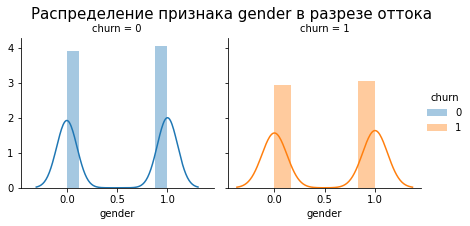

<Figure size 1080x1080 with 0 Axes>

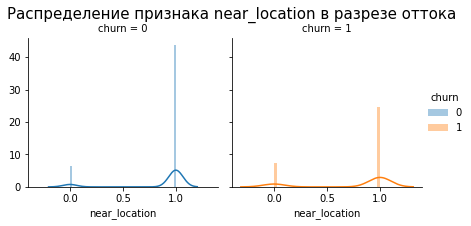

<Figure size 1080x1080 with 0 Axes>

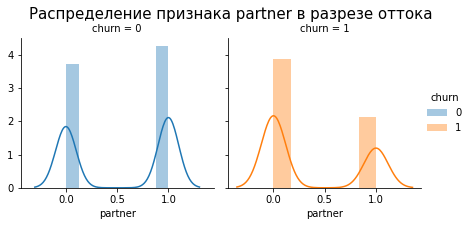

<Figure size 1080x1080 with 0 Axes>

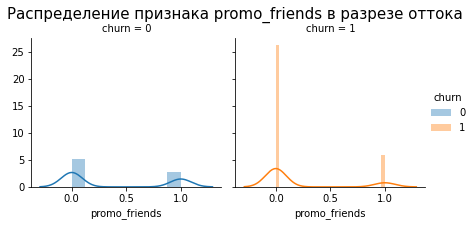

<Figure size 1080x1080 with 0 Axes>

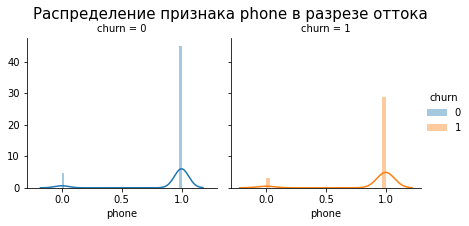

<Figure size 1080x1080 with 0 Axes>

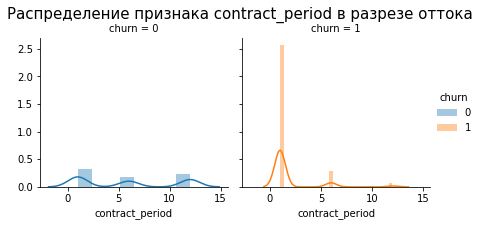

<Figure size 1080x1080 with 0 Axes>

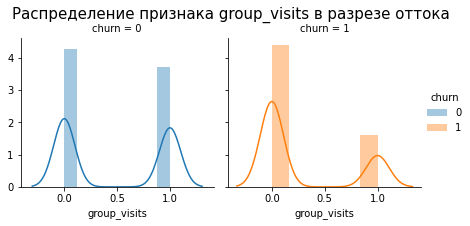

<Figure size 1080x1080 with 0 Axes>

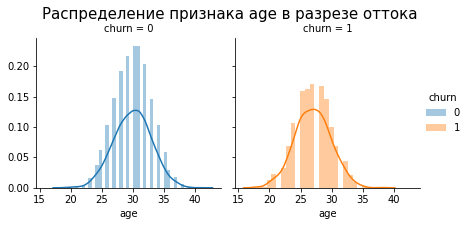

<Figure size 1080x1080 with 0 Axes>

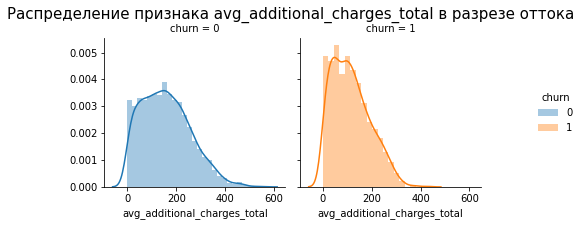

<Figure size 1080x1080 with 0 Axes>

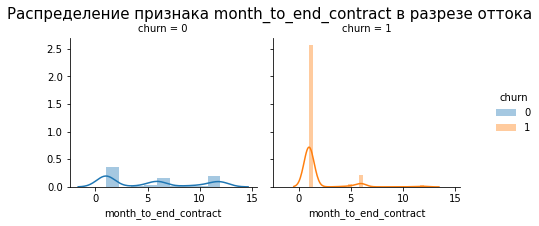

<Figure size 1080x1080 with 0 Axes>

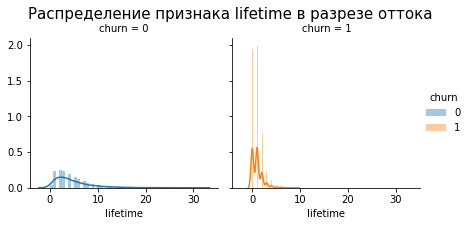

<Figure size 1080x1080 with 0 Axes>

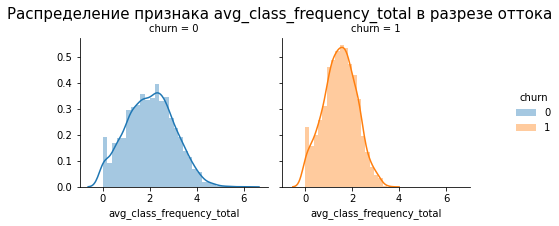

<Figure size 1080x1080 with 0 Axes>

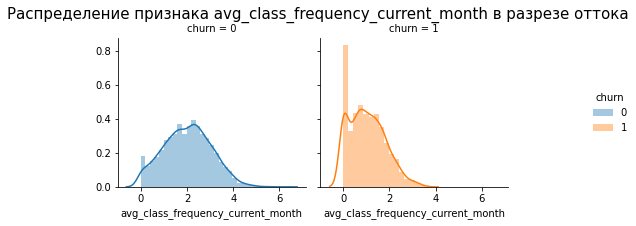

<Figure size 1080x1080 with 0 Axes>

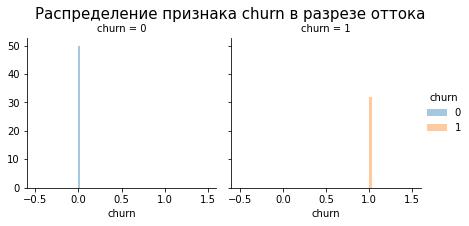

In [15]:
#Чтобы постороить графики всех признаков, создадим цикл по столбцам нашей таблицы
#
for column in gym_churn.columns:
    
    plt.figure(figsize=(15, 15))
    #загружаем объект для постороения многосегментного графика
    grid = sns.FacetGrid(gym_churn, col="churn", hue="churn")
    #вызываем метод map() для простороения самих графиков
    grid.map(sns.distplot, column)
    #визуализируем легенду на графиках
    grid.add_legend()
    # Устанавливаем общий заголовок
    grid.fig.suptitle(f'Распределение признакa {column} в разрезе оттока',
               y = 1.03,
               fontsize = 15)
plt.show()    

- Чаще уходят те клиенты, которые проживают в том же райорне, что и фитнесс-центр. Будем помнить, что клиентов, которые находятся рядом с центрами, в принципе, больше.
- Гораздо чаще уходят клиенты, которые взяли абонемент на месяц.
- Те клиенты, которые посещают групповые тернировки остаютя посетителями фитнесс-центров чаще, чем те клиенты, которые находятся в зале.
- Чаще уходят клиенты в возрастном сегменте от 25-30, основными поситителями центра являются клиенты 30 лет.
- Остаются клиенты, которые дополнительно тратят свои средства.
- Набдлюдается сильный отток у клиентов, у которых остается один месяц контракта .
- Отток клиентов наблюдается у тех пользователей фитнесс-центром, которые ходили до 1 месяца, либо вообще не воспользовались, есть нулевые значения.
- Остаются клиенты, которые посещают фитнесс-центр 2 раза в неделю. Отток наблюдается у клиентов, которые посещают 1 раз в неделю.
- В данных за количество посещений в неделю в текущем месяце, наблюдается больше количество нулевых посещений в оттоке. Ушли клиенты, которые даже ни разу не поситили центр.
- Около 27% от общего числа клиентов, составляет отток клиентов.

В целом, то что показывают данные логично, ярких выбросов не наблюдалось, можно предположить, что данные корректны и на них удастся сделать прогнозы.

Построим матрицу корреляций и тепловую карту

In [16]:
cm = gym_churn.corr() #вычисляем матрицу корреляций
cm

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
near_location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


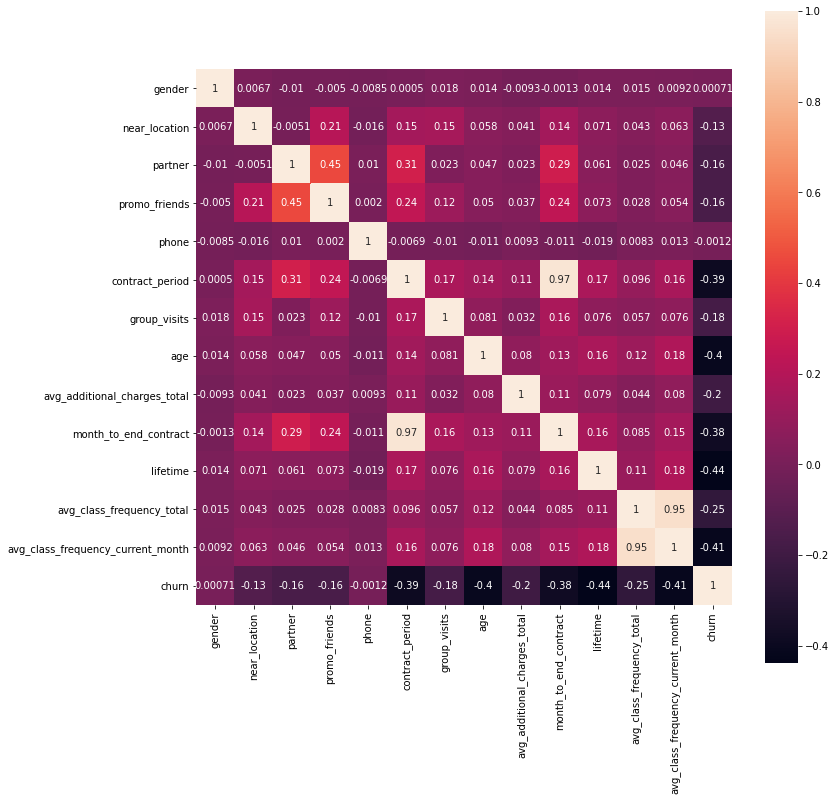

In [17]:
#нарисуем тепловую карту с подписями для матрицы корреляций

plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, square=True) 

plt.show()

Сильно коррелируют между собой 4 признака:
- кол-во месяцев до окончания контракта и период контракта
- среднее посещения ценра в неделю за месяц и за весь период

С целевой переменной (Отток) корреляций не замечено, более того, корреляция со всеми признакми отрицательная.

## Прогноз оттока клиентов

В силу того, что целевая переменна 'churn' несет информацию в бинарном виде, то мы выберем алгоритмы бинарных моделей.  
Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.  
Модели, которыми воспользуемся:
- LogisticRegression (логистическая регрессия)
- RandomForestClassifier (случайный лес)

In [18]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = gym_churn.drop('churn', axis=1)
y = gym_churn['churn']

# разбьем данные на обучающую и валидационную выборку функцией train_test_split()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# обучите StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# Преобразуйте обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)


#задаем алгорит для модели с параметром solver для логистической регрессии
lr_model = LogisticRegression(random_state=0)
#задаем алгорит для модели с параметром n_estimators для случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state=0)



# обучаем модели 
lr_model.fit(X_train_st, y_train)
rf_model.fit(X_train, y_train)

# делаем прогнозы
lr_y_pred = lr_model.predict(X_test_st)
lr_y_prob = lr_model.predict_proba(X_test_st)[:,1]
rf_y_pred = rf_model.predict(X_test)
rf_y_prob = rf_model.predict_proba(X_test)[:,1]

#расчет метрик

# функция, которая принимает на вход y_test, y_pred и выводит метрики, m-название алгоритма модели
def make_metrics(m, y_test, y_pred, y_proba):
    print(f'Метрики для модели {m}:\n',
        '- метрика доли правильных ответов acc:{:.2f}\n - метрика точности precision:{:.2f}\n - метрика полноты recall:{:.2f}\n - площадь под кривой ошибок AUC-ROC:{:.2f}'.format(
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred),
            roc_auc_score(y_test, y_proba)
           )
         )

# вывод на экран

print(make_metrics('LogisticRegression', y_test, lr_y_pred, lr_y_prob))
print(make_metrics('RandomForestClassifier', y_test, rf_y_pred, rf_y_prob))


Метрики для модели LogisticRegression:
 - метрика доли правильных ответов acc:0.92
 - метрика точности precision:0.85
 - метрика полноты recall:0.83
 - площадь под кривой ошибок AUC-ROC:0.97
None
Метрики для модели RandomForestClassifier:
 - метрика доли правильных ответов acc:0.92
 - метрика точности precision:0.84
 - метрика полноты recall:0.82
 - площадь под кривой ошибок AUC-ROC:0.97
None


Обе модели показывают хороший результат.  
Модели с 97% вероятностью показывают прогноз оттока клиента, что весьма неплохо.  
Верные ответы показывают тоже с одинаковой вероятностью - 92%.  
Метрику точности (precision) и полноты (recall) модель логистической регрессии показывает на 1% точнее, чем модель случайного дерева.  
Для нас важна метрика recall, т.к. она показывает с какой долей вероятности мы обнаружили клиентов оттока с помощью обученной модели.  
Результат 83% и 82% логистической регрессии и случайного дерева, соответсвенно, не самые идеальные.


## Кластеризация клиентов

Для кластеризации данных построим дендрограмму, что позволит визуализировать соотношения между клиентами.  
Стандартизируем данные и применим методы для построения дендрограммы.

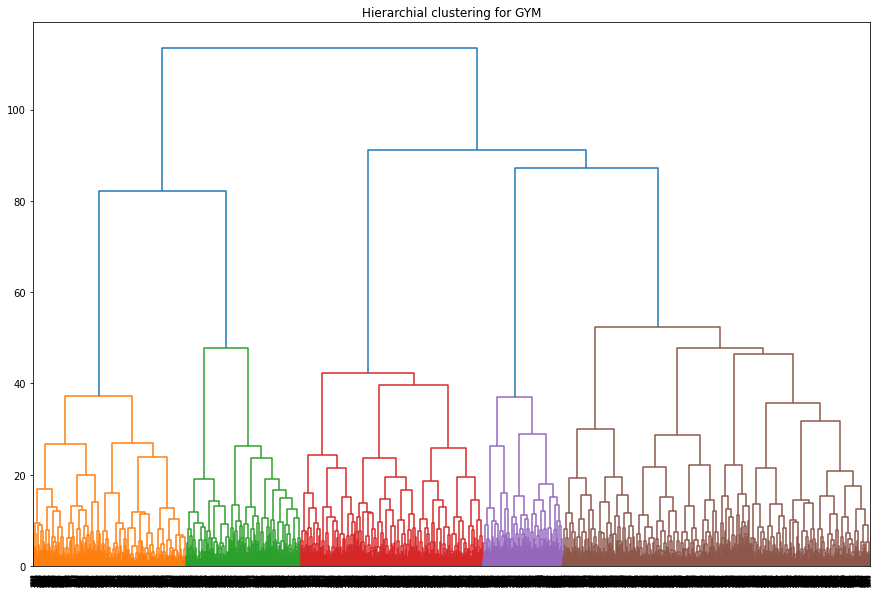

In [19]:
# стандартизируем данные
sc = StandardScaler()
x_sc = sc.fit_transform(gym_churn)

#таблица «связок» между объектами
linked = linkage(x_sc, method = 'ward')
#визуализация дендрограммы
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show()

На графике пять разных цветов, метод предложил нам самое оптимальное количество кластеров-5.  
Возьмем это количество кластеорв и обучим модель на основании алгоритма K-Means.

In [20]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters = 5, random_state=0) # задаём число кластеров, равное 5 и фиксируем значения random_state
labels = km.fit_predict(x_sc) # применяем алгоритм к данным и формируем вектор кластеров

# сохраняем метки кластера в поле нашего датасета
gym_churn['cluster_km'] = labels
#print(gym_churn['cluster_km'].head())

# выводим статистику по средним значениям наших признаков по кластеру
cluster_gym=gym_churn.groupby('cluster_km', as_index=True).mean()

display(cluster_gym)


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.503676,0.000000,0.459559,0.075368,0.917279,2.069853,0.211397,28.522059,132.741216,1.950368,2.757353,1.706629,1.515890,0.450368
1,0.492829,0.936115,0.764016,0.534550,0.919166,10.447197,0.516297,29.962190,161.853561,9.477184,4.833116,2.788103,2.786919,0.007823
2,0.507917,1.000000,0.323995,0.213155,0.903776,1.546894,0.287454,26.926918,113.173051,1.500609,1.031669,1.449720,1.037592,0.961023
3,0.521186,0.996610,0.282203,0.208475,0.904237,1.882203,0.452542,30.237288,157.988625,1.794915,4.923729,2.203432,2.207359,0.003390
4,0.518895,0.968023,0.744186,0.526163,0.873547,8.859012,0.534884,29.728198,162.907495,8.155523,4.411337,0.957744,0.943967,0.024709


Замечено, что кластеры распределены по периоду заключенного контракта, ушел клиент или остался, проживает или работает в районе фитнес-центра.

Построим распределения признаков для кластеров

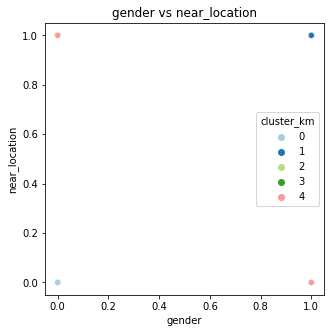

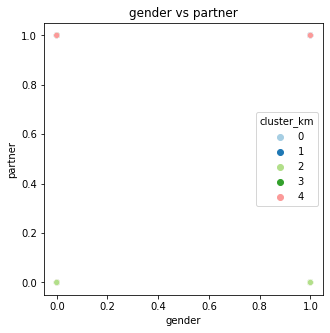

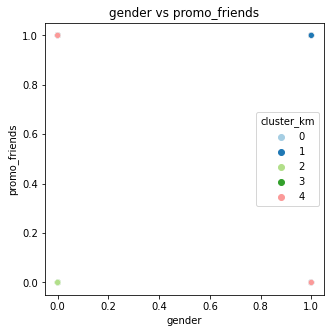

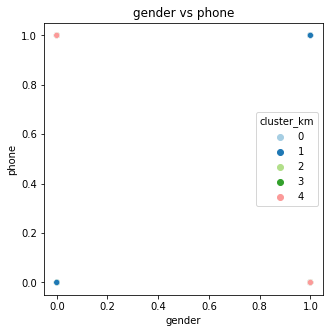

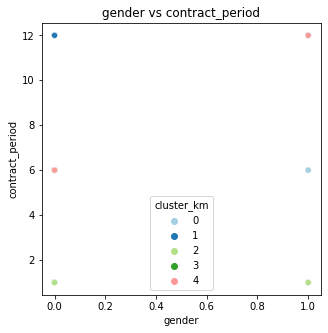

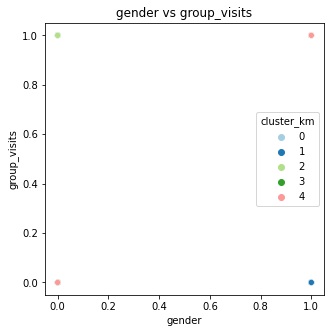

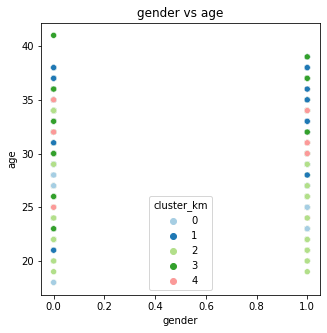

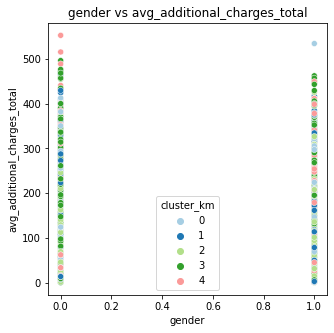

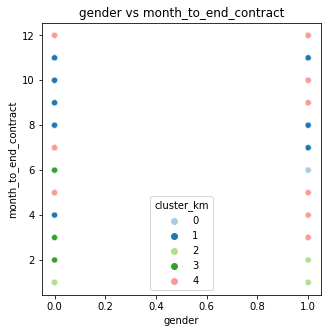

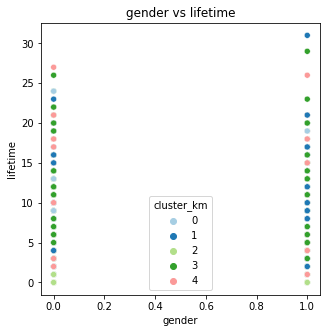

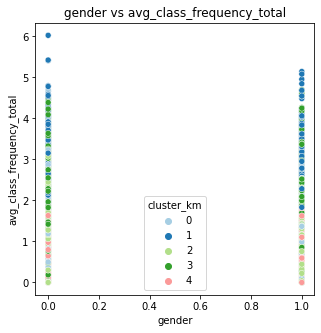

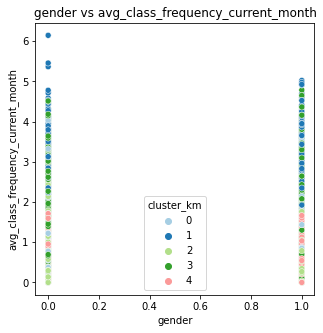

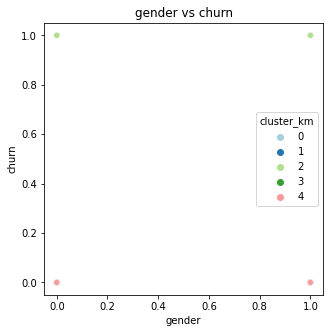

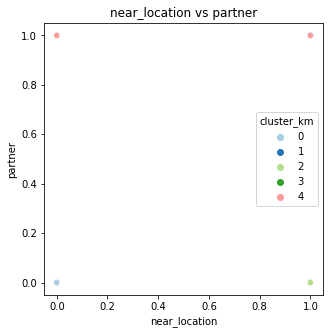

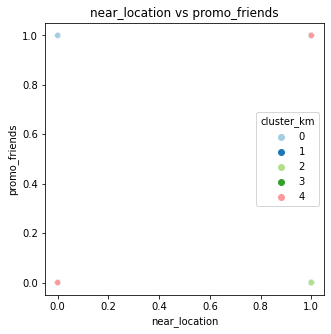

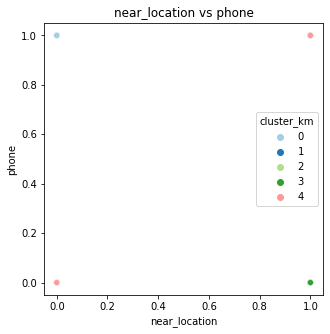

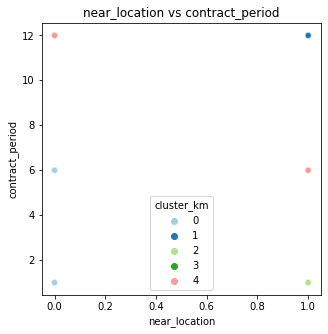

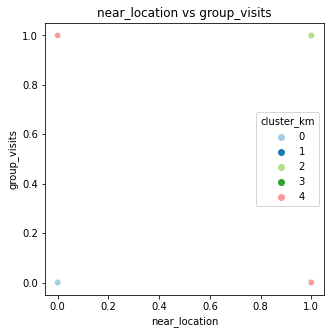

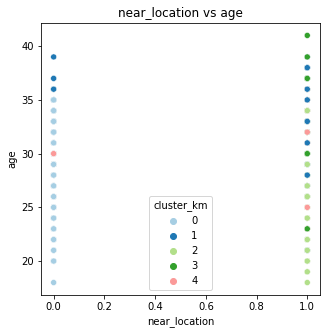

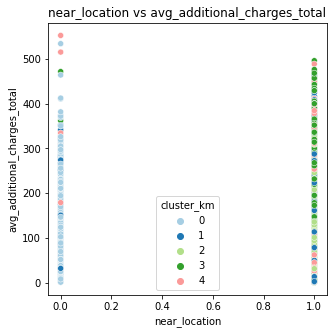

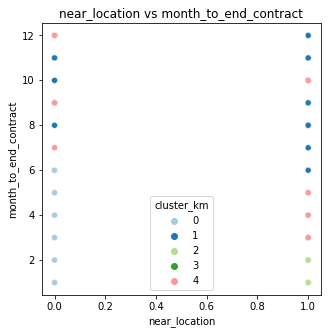

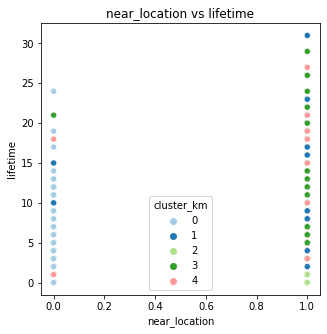

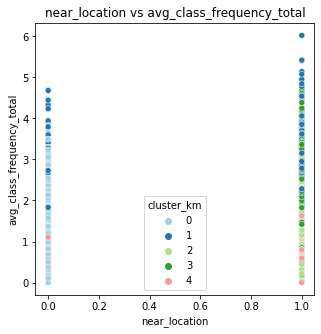

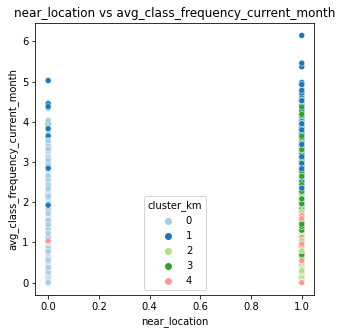

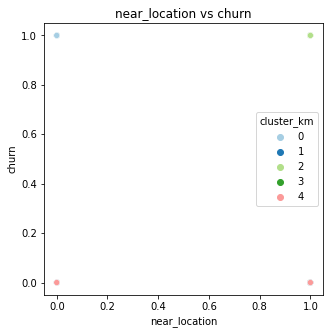

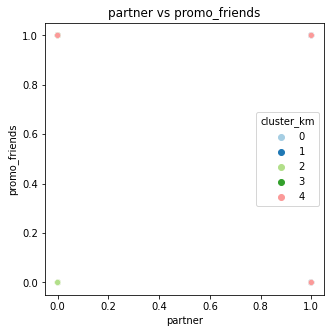

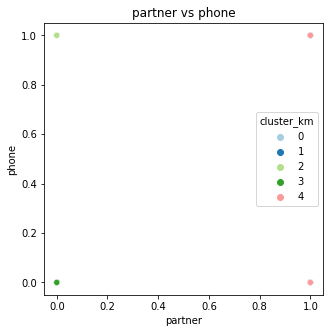

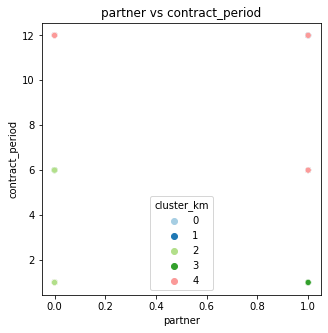

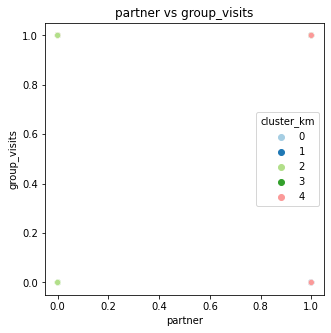

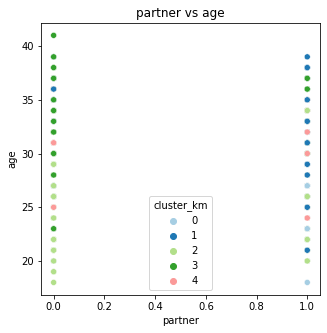

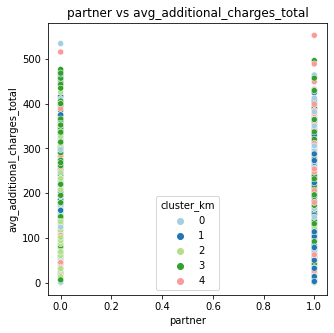

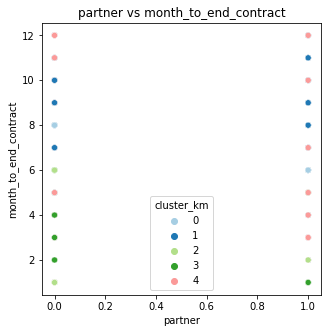

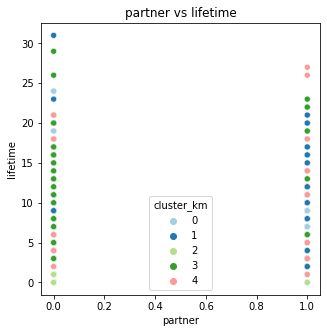

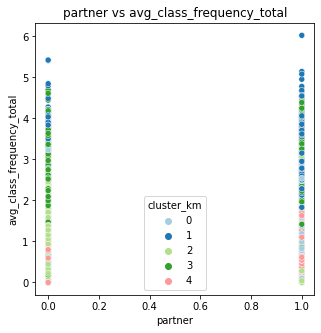

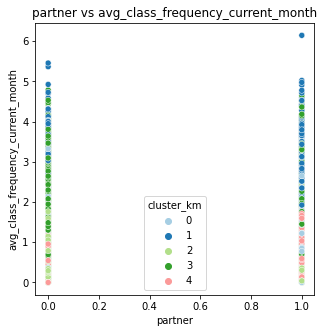

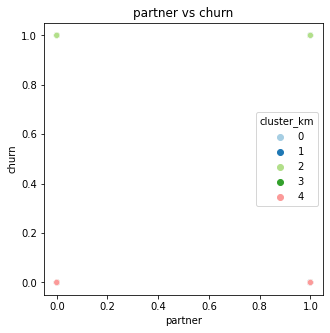

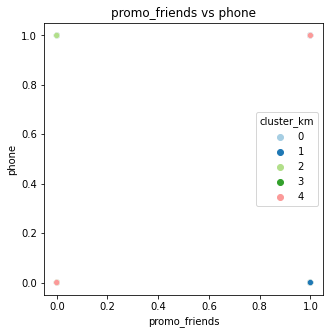

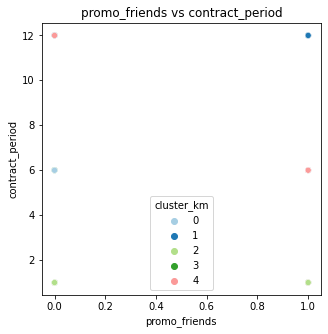

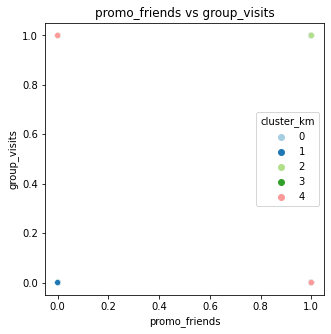

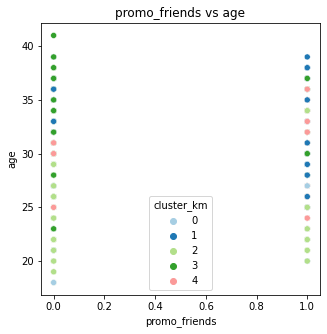

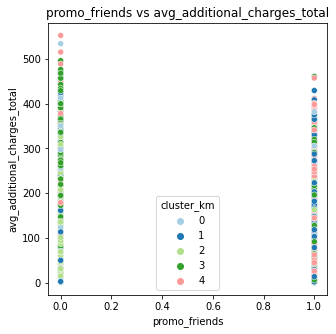

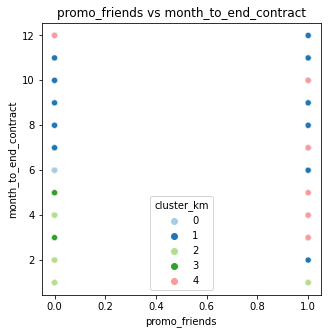

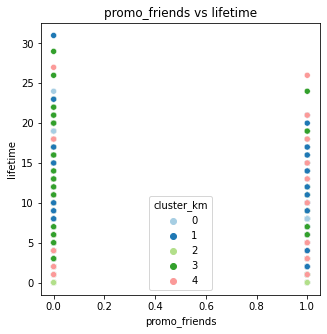

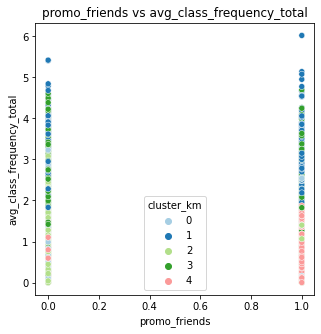

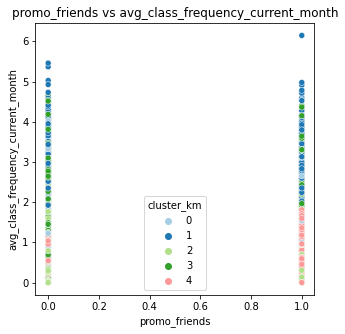

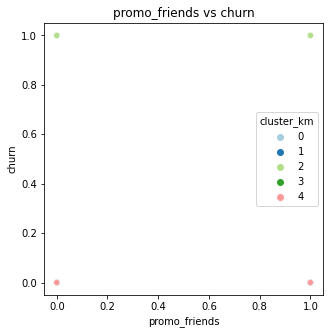

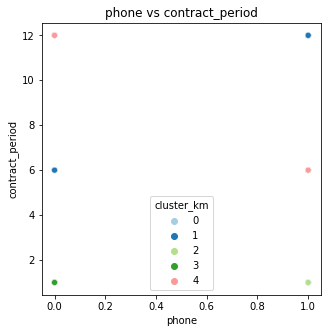

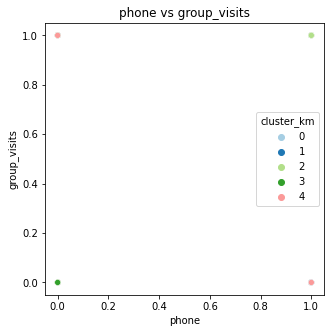

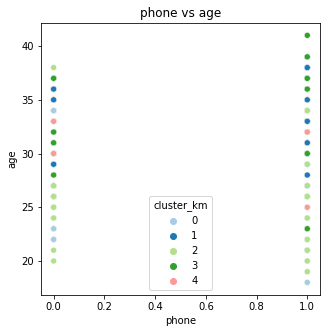

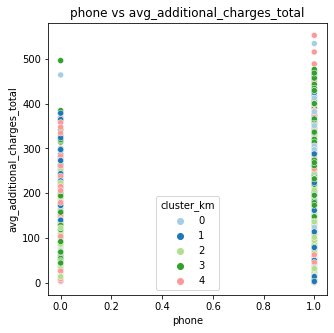

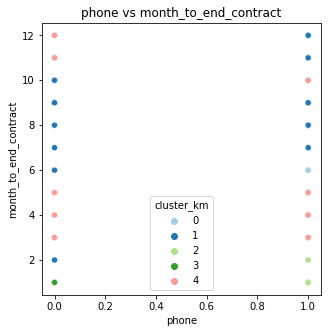

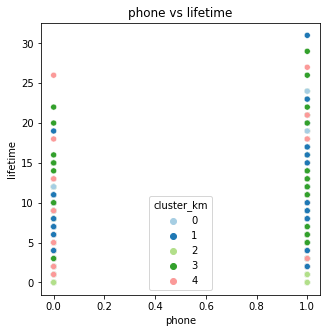

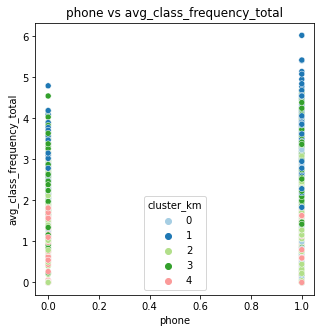

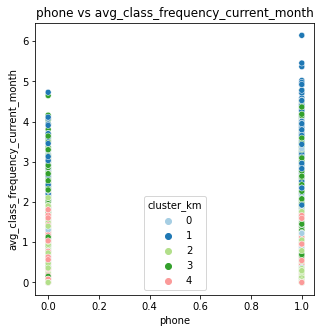

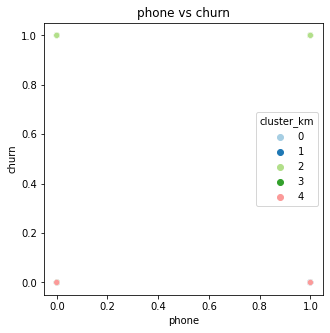

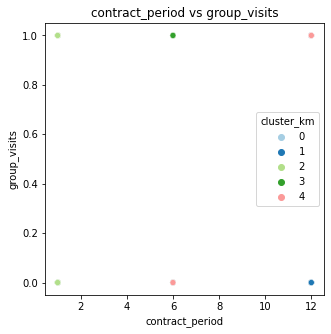

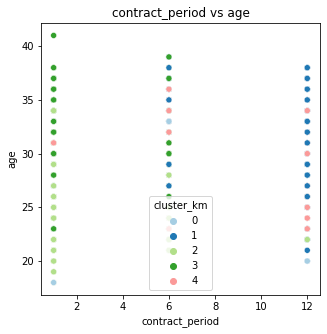

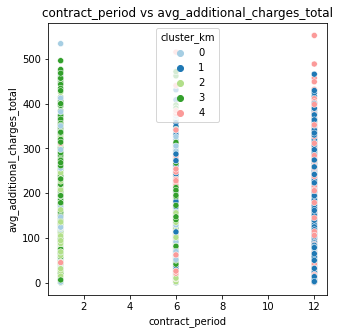

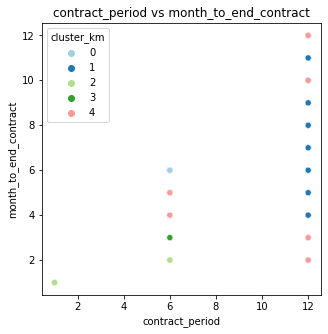

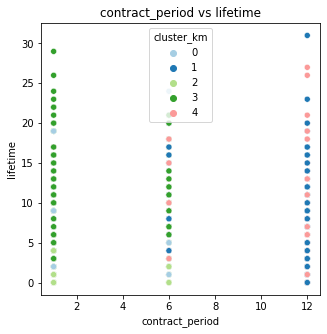

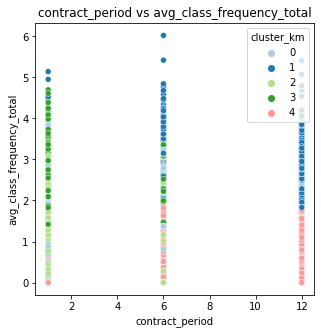

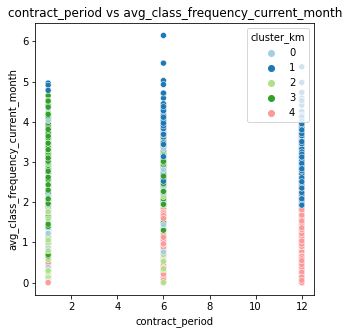

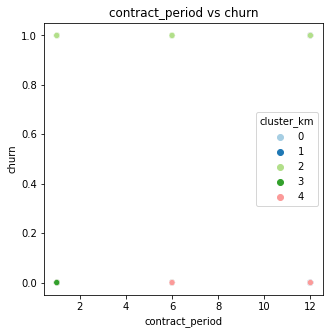

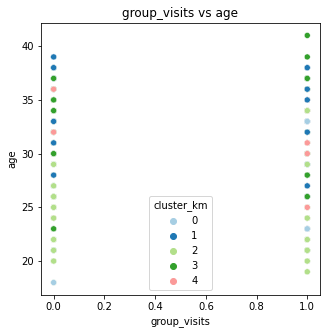

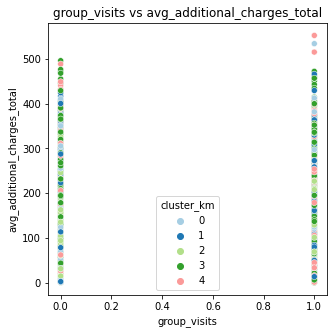

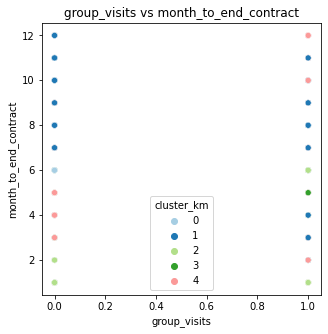

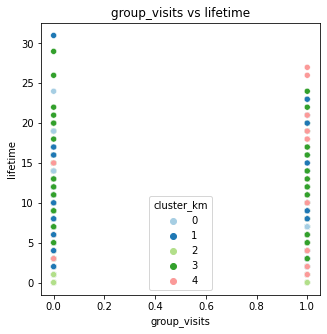

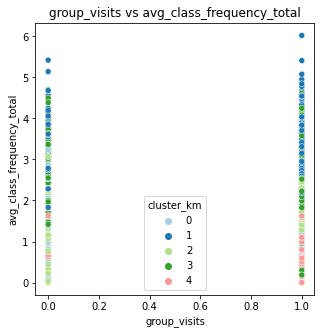

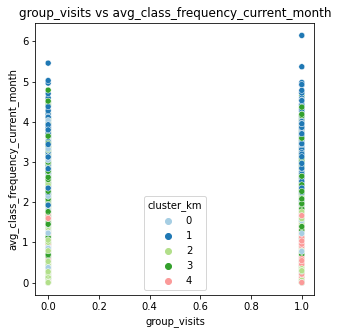

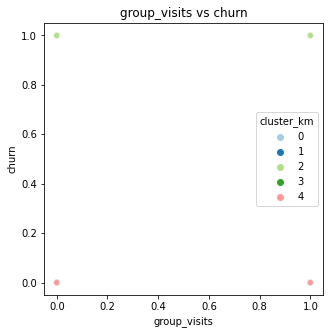

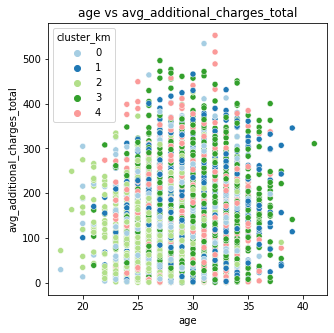

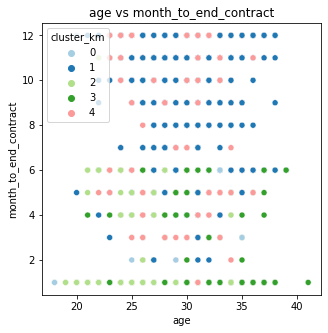

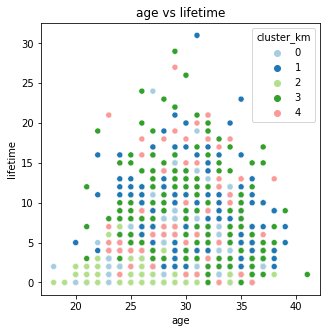

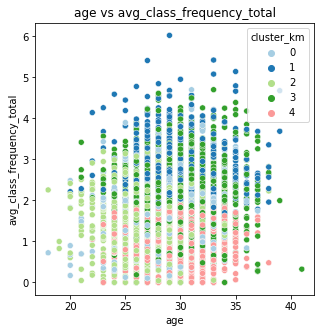

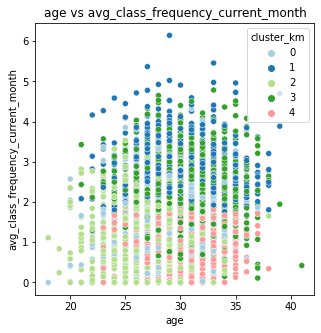

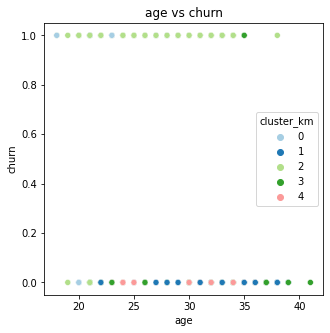

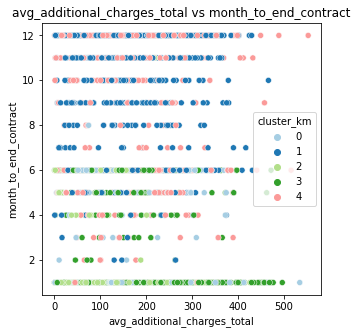

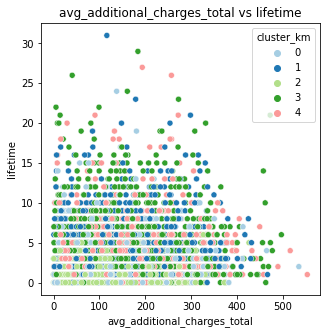

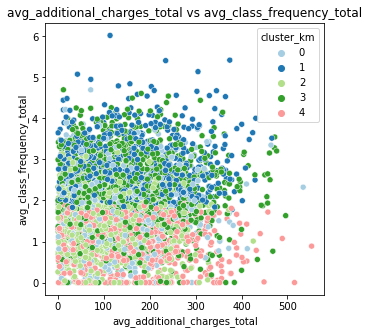

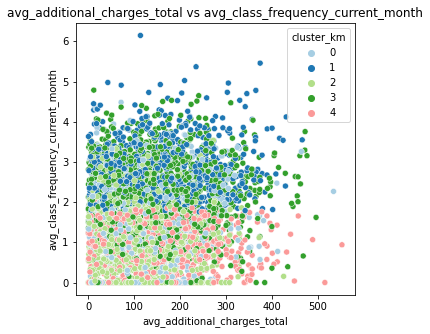

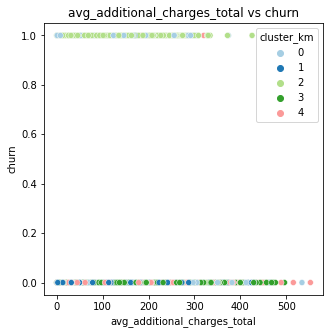

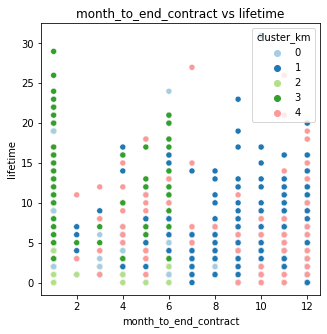

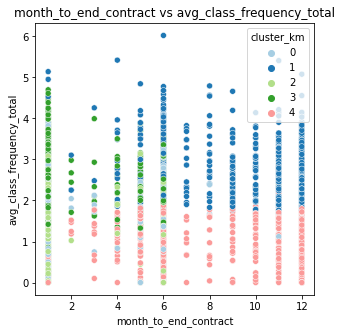

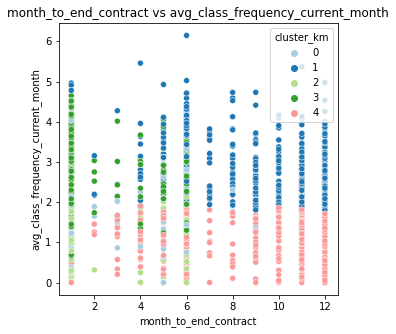

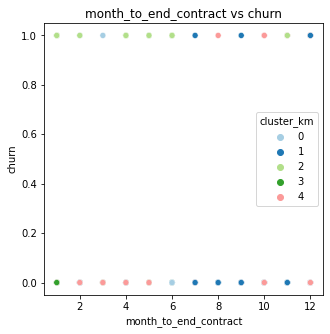

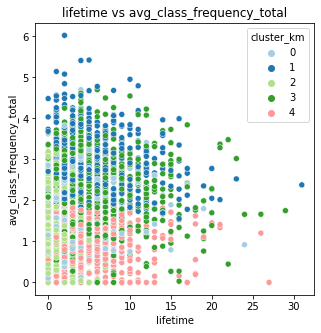

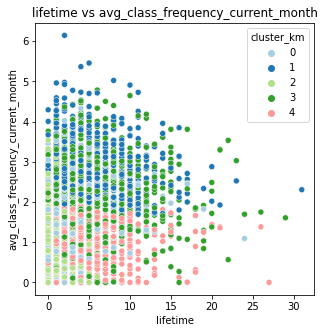

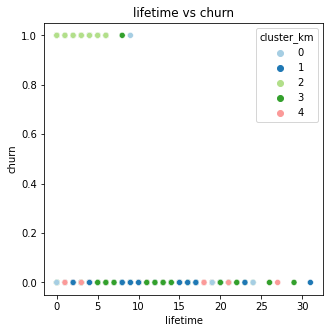

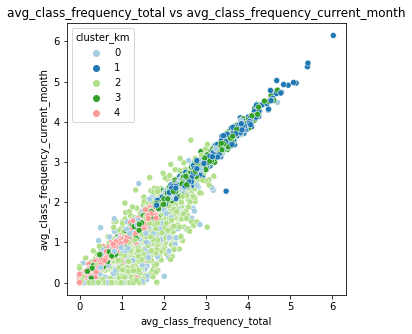

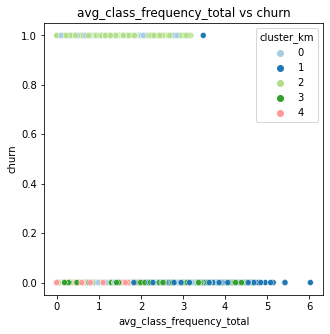

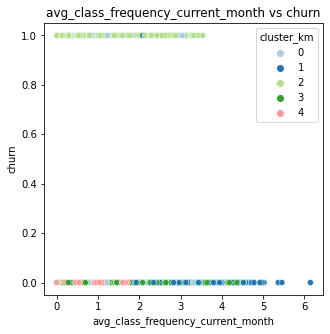

In [21]:
from itertools import combinations

# определим функцию отрисовки графиков попарных признаков для кластеров
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        df[x_name], df[y_name], hue=df[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

# отрисуем графики для попарных сочетаний признаков с разметкой по кластерам

col_pairs = list(combinations(gym_churn.drop('cluster_km', axis=1).columns, 2))
for pair in col_pairs:
    show_clusters_on_plot(gym_churn, pair[0], pair[1], 'cluster_km')

На основании графиков распределения можно сделать выводы, что кластеры распределены по-разному.  
Некоторых распределений признаков остутсвуют кластеры, в большинстве случаев распределены равномерно, но так-как у некоторых признаков булевый характер данных, то распределены равномерно и в 0, и в 1.  
Также наблюдается пограничные признаки для некоторых кластеров:  
- возраст и средняя частота посещений в неделю/за предыдущий месяц
- кол-во месяцев до окончания абонимента и средняя частота посещений в неделю/за предыдущий месяц
- суммарная выручка и средняя частота посещений в неделю/за предыдущий месяц
- лайфтайм и средняя частота посещений в неделю/за предыдущий месяц   


В основном пограничнное распреденение наблюдалось только с признаками средней частоты посещений в неделю/за предыдущий месяц.  
На попарных графиках этих признаков видно, что группы не сильно пересекаются между собой.  
На попарном графике оттока и распределения средней частоты посещений в неделю и средней частоты посещений в неделю за предыдущий месяц есть явное разделение одной группы от всех, которая находится в признаке оттока клиентов.
  

Для каждого признака рассмотрим распределение по кластерам.

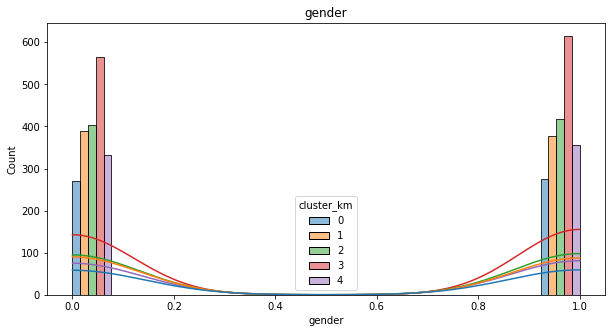

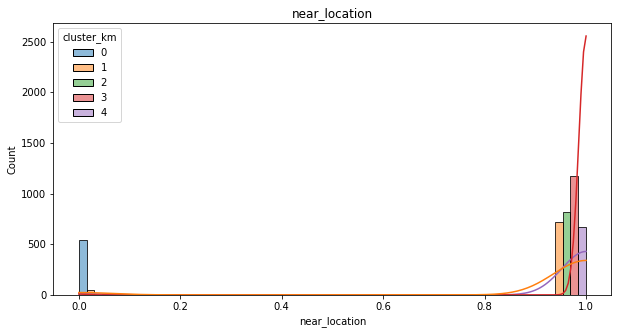

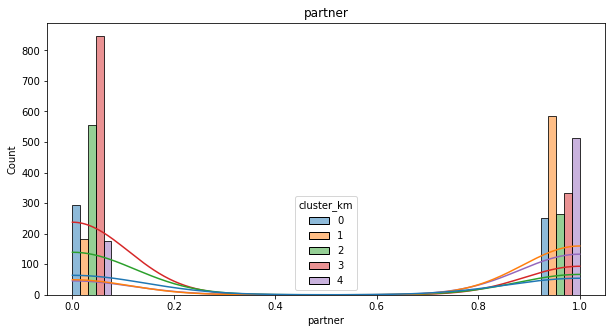

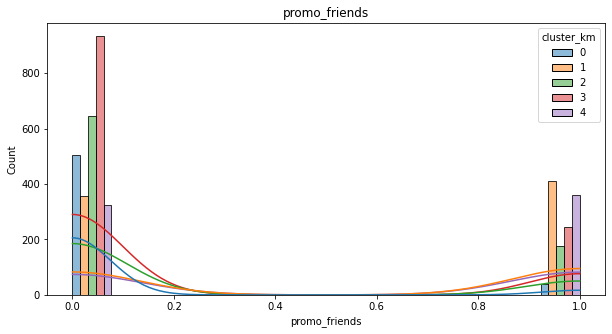

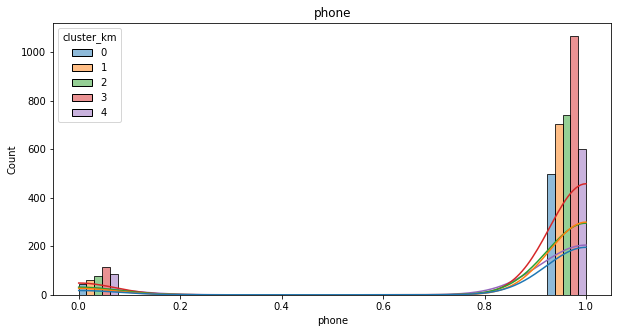

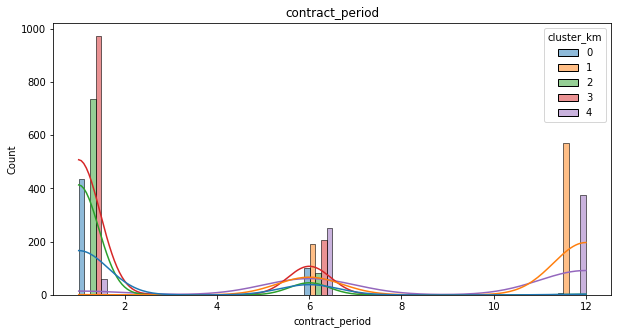

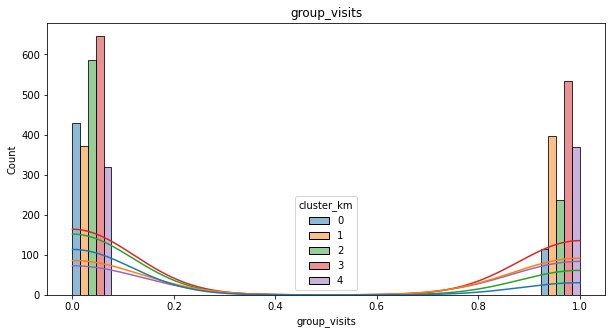

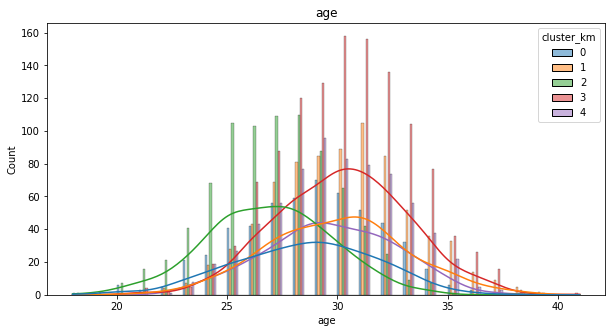

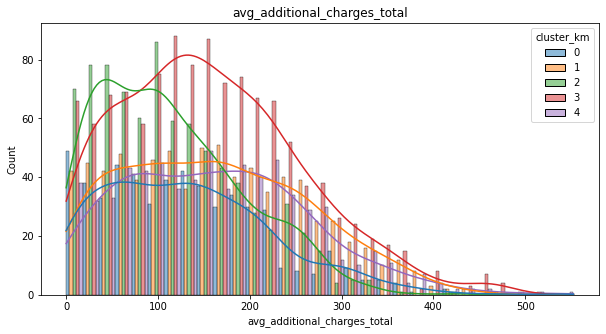

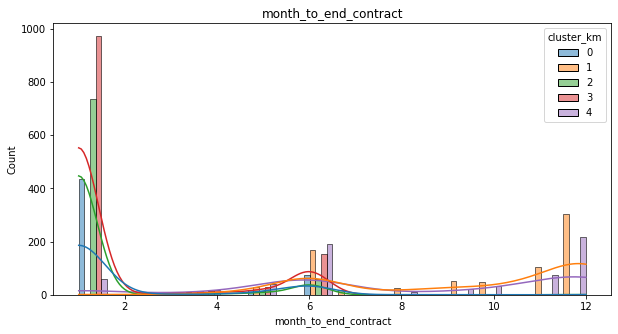

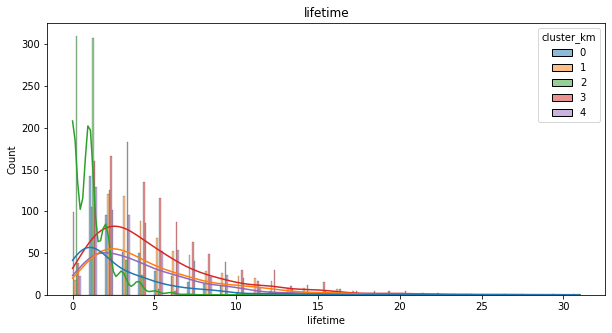

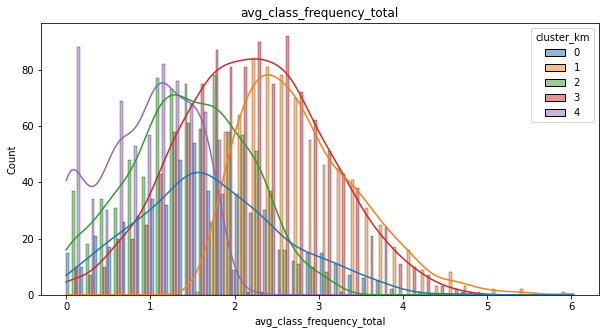

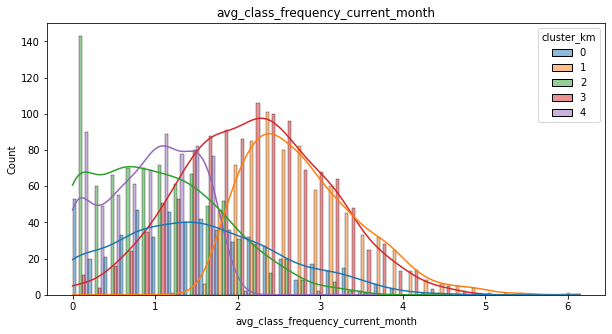

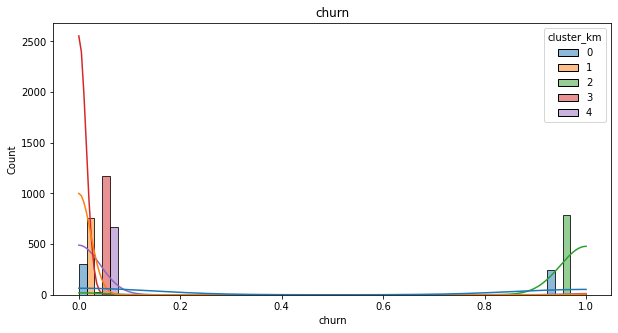

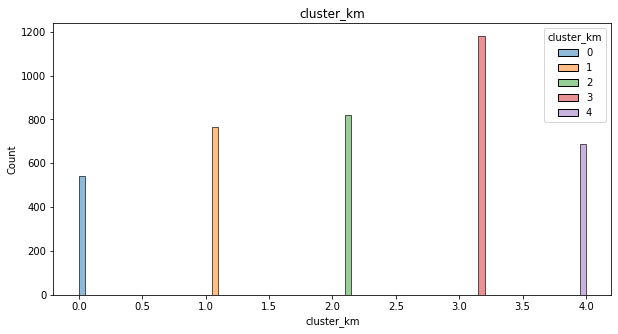

In [31]:
for column in gym_churn.columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(gym_churn, x=column, hue='cluster_km', kde=True, multiple='dodge', palette = 'tab10')
    plt.title(column)
    plt.show()

Для каждого полученного кластера посчитаем долю оттока.

In [36]:
#группируем по кластерам
#считаем кол-во клиентов, которые попали в отток
#делим их на общее кол-во клиентов и находим долю оттока клиентов

gym_churn.groupby('cluster_km').agg({'churn': 'sum'}).apply(lambda x: (x/4000)*100).rename(columns={'churn': '% доли оттока клиентов'})

,% доли оттока клиентов
cluster_km,
0,6.125
1,0.150
2,19.725
3,0.100
4,0.425


Все кластеры находятся в сегменте от 13% до 30% доли оттока клиентов.  
Меньше всего покидают фитнес-центры клиенты из 0 кластера около 14% от общего числа клиентов, чаще всего уходят клиенты из 3 кластера - 30% клиентов от общего числа клиентов.  

По особенностям характеров кластеров, можно выделить следующее:  
- *0 кластер* - является самым маленьким кластерем, у клиентов остался 1 месяц до окончания контракта, все клиенты из этого кластера находятся в отличных районах от района фитнес-центров.  
- *1 кластер* - это частые посетители фитнес-центров и ходят регулярно, у них продолжительный срок абонементов действует от полугода до года. Многие клиенты этого кластера воспользовались услугой "приведи друга".
- *2 кластер* у показателей этого кластера самый большой процент оттока клиентов. В текущем месяце самый большой показатель по НЕ продолжительности заключенного контракта. Возратсная категория до 25 лет.
- *3 кластер* - самый крупный кластер по количеству клиентов. Клиентов, которые ушли в отток в этом кластере нет. Клиенты 3 кластера ходят в фитнес зал стабтльно от 2-3 раз и больше всех дополнительно тратят средства.
- *4 кластер* - не сожержит клиентов, которые попали в отток. Для клиентов 4 кластера характерны редкие посещения фитнес-центра, в неделю от 0-2 раз, а за текущий месяц клиенты из этого кластера практичести не посещали фитнес-центры. Клиентам этого кластера являются приемущетственно лица 30 лет.


## Выводы и рекомендации

Данные подготовлены, выбросов, отсутсвующих значений в них нет.  
Все параметры корректны, некоторые между собой коррелируют, что весьма правдоподобно и указывает нам на возможность обучить модель для более точного прогноза оттока клиентов.  
Модель обучена и показывает хорошие результаты обучения.  
Возможно разделение клиентов на 5 групп, для точного анализа и более тонкого понимания, как можно удержать клиента из той или иной группы.  

*Рекомендации:*
- обратить внимание на тех клиентов, у которых остался последний месяц по контракту, они чаще всего уходят; 
- провести работу по удержанию клиентов с возрастной группой от 25-30 лет;
- мотивировать клиентов на увеличение количества посещений в неделю;
- стоит рассмотреть категорию клиентов, которые занимаются с тренером;
- разделить клиентов на целевые группы и найти подход по удержанию к каждой группе;
- делать беплатные пробные групповые занятия, чтобы клиенты-одиночки смогли вливаться в жизнь фитнес-центра;
- поощрать клиентов, которые посещают фитнес 3 и более раз в неделю, различными скидками.

<div class="alert alert-success">
<b> ✔️ Комментарий ревьювера (v2):</b> Вообще логистическая регрессия позволяет определять вероятность принадлежности одному или другому классу, на основе чего определяется метка класса — 0 или 1. То есть мы решаем задачу классификация.
    
Линейная регрессия выдает непрерывное число. Сам термин «регрессия» появился исторически.
    
В данной задаче в качестве альтернативной модели мы выбираем RandomForestClassifier, для классификации. 
    
Также например модель LGBMRegressor или LGBMClassifier соответственно для регрессии и классификации.
    
https://ml-handbook.ru/ есть вот такой онлайн учебник. Здесь в доступном виде описаны теоретические основы некоторых моделей — линейные, случайный лес, градиентный бустинг. В первой главе Линейные модели как раз рассказывают про отличие задач регрессии и классификации.
    
Надеюсь ответил на твой вопрос и стало понятнее =)
    
</div>